In [13]:
import os
import sys
from pathlib import Path
import time
from pyglet.window import key
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import_path = str(Path(os.getcwd()).parent.parent)
sys.path.insert(0, import_path)

from WorldModelsExperiments.breakout.model import Model, make_model, _process_frame

In [14]:
path = '/home/student/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200522'
rnn_path = path + '/tf_rnn/rnn.json'
vae_path = path + '/tf_vae/vae.json'
controller_path = path + '/log/carracing.cma.16.64.best.json'
env_name = 'CarRacing'
model = make_model(env_name, rnn_path=rnn_path, vae_path=vae_path)
model.load_model(controller_path)
print('models loaded')

INFO:tensorflow:Model using cpu.


[2020-05-27 12:26:44,623] Model using cpu.


loading file /home/student/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200522/log/carracing.cma.16.64.best.json
models loaded


In [15]:
reward_list = []
obs_sequence = np.zeros(shape=(10000,96,96,3), dtype=np.uint8)
tsne_data = pd.DataFrame()

global human_sets_pause, key_to_action
human_sets_pause = False
num_episode = 1

In [16]:
def key_press(symbol, mod):
    global human_sets_pause
    if symbol == key.SPACE:
        human_sets_pause = not human_sets_pause

#### Start normal game until pause manually

In [41]:
def play_game(model, num_episode=1, render_mode=True):
    global human_sets_pause
    human_sets_pause=False
    reward_list = []
    obs_sequence = np.zeros(shape=(10000, 96, 96, 3), dtype=np.uint8)
    # tsne_data = pd.DataFrame()

    for episode in range(num_episode):
        total_reward = 0
        obs = model.env.reset()
        done = False
        seq_counter = 0

        while not done:
            model.env.render('human')
            model.env.unwrapped.viewer.window.on_key_press = key_press

            obs = _process_frame(obs)
            z, mu, logvar = model.encode_obs(obs)
            action, _ = model.get_action(z)
            obs, reward, done, info = model.env.step(action)

            #data = np.concatenate([z, model.state.h[0]]).reshape(1, 288)
            #tsne_data = tsne_data.append(pd.DataFrame(data), ignore_index=True)
            obs_sequence[seq_counter, :, :, :] = obs
            total_reward += reward
            seq_counter += 1
            #time.sleep(0.2)

            if human_sets_pause:
                time.sleep(1)
                print('render for several steps done, shift with current reward: ', total_reward)
                time.sleep(2)
                human_sets_pause = False
                model.env.viewer.close()
                model.env.viewer = None
                print('close env')
                break

        if done:
            print('game episode ', str(episode), ' is done with total reward: ', total_reward)
            if render_mode:
                model.env.viewer.close()
                model.env.viewer = None
                # model.env.close()
                print('close env')
            return obs_sequence, seq_counter
        time.sleep(2)
    return obs_sequence, seq_counter, total_reward, obs, action

In [53]:
obs_sequence, seq_counter, total_reward, obs, action = play_game(model)

Track generation: 1365..1709 -> 344-tiles track
render for several steps done, shift with current reward:  38.56268221574338
close env


#### Video Sequence

In [38]:
import base64
import imageio
import IPython
from PIL import Image

In [39]:
def embed_mp4(filename,video):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [39]:
filename = 'obs_sequence.mp4'
with imageio.get_writer(filename, mode='I', macro_block_size=None) as video:    
    for image in range(counter):
        video.append_data(obs_sequence[image])
embed_mp4(filename,video)

In [54]:
pause_state = {}

In [55]:
pause_state['car'] = model.env.car
pause_state['prev_reward'] = model.env.prev_reward
pause_state['reward']= model.env.reward
pause_state['road'] = model.env.road
pause_state['road_poly']=model.env.road_poly
pause_state['score_label'] = model.env.score_label
pause_state['start_alpha'] = model.env.start_alpha
pause_state['env_state'] = model.env.state
pause_state['t'] = model.env.t
pause_state['tile_visited_count']= model.env.tile_visited_count
pause_state['track'] = model.env.track
pause_state['rnn_state'] = model.state
pause_state['total_reward'] = total_reward
pause_state['seq_counter'] = seq_counter
pause_state['obs'] = obs
pause_state['obs_sequence'] = obs_sequence[:seq_counter,:,:,:]
pause_state['action'] = action

In [56]:
print('Pause reward', pause_state['total_reward'])
print(pause_state['obs_sequence'].shape)
print(seq_counter)


Pause reward 38.56268221574338
(110, 96, 96, 3)
110


#### OPTION 1 : Continue game NORMAL

In [57]:
pause_state['action']

array([ 0.3235,  0.9997,  0.    ])

In [58]:
#OPTION 1: NORMAL
# todo add several black images to simulate pause
obs_normal = np.zeros(shape=(3000,96,96,3), dtype=np.uint8)
obs_normal[:pause_state['seq_counter']]= pause_state['obs_sequence']
seq_counter = pause_state['seq_counter'] +7
total_reward = pause_state['total_reward']
obs = pause_state['obs']
model.state = pause_state['rnn_state']

model.env.car = pause_state['car']
model.env.prev_reward = pause_state['prev_reward']
model.env.reward = pause_state['reward']
model.env.road = pause_state['road']
model.env.road_poly = pause_state['road_poly']
model.env.score_label = pause_state['score_label']
model.env.start_alpha = pause_state['start_alpha']
model.env.state = pause_state['env_state']
model.env.t = pause_state['t']
model.env.tile_visited_count = pause_state['tile_visited_count']
model.env.track = pause_state['track']

done = False

while not done and seq_counter<150:
    obs = _process_frame(obs)
    z, mu, logvar = model.encode_obs(obs)
    action, _ = model.get_action(z)
    obs, reward, done, info = model.env.step(action)
    model.env.render('human')
    
    obs_normal[seq_counter,:,:,:] = obs
    total_reward += reward
    seq_counter +=1

print('Episode is done with total reward: ', total_reward)
model.env.viewer.close()
model.env.viewer = None

Episode is done with total reward:  571.2539358600507


In [46]:
filename = 'obs_sequence_normal.mp4'
with imageio.get_writer(filename, mode='I', macro_block_size=None) as video:    
    for image in range(seq_counter):
        video.append_data(obs_normal[image])
embed_mp4(filename,video)

#### OPTION 2 : Continue game SHIFT TO RIGHT

In [59]:
pause_state['action']

array([ 0.3235,  0.9997,  0.    ])

In [60]:
#OPTION 2: RIGHT
obs_right = np.zeros(shape=(3000,96,96,3), dtype=np.uint8)
obs_right[:pause_state['seq_counter']]= pause_state['obs_sequence']
seq_counter = pause_state['seq_counter'] +7
total_reward = pause_state['total_reward']
obs = pause_state['obs']
model.state = pause_state['rnn_state']

model.env.car = pause_state['car']
model.env.prev_reward = pause_state['prev_reward']
model.env.reward = pause_state['reward']
model.env.road = pause_state['road']
model.env.road_poly = pause_state['road_poly']
model.env.score_label = pause_state['score_label']
model.env.start_alpha = pause_state['start_alpha']
model.env.state = pause_state['env_state']
model.env.t = pause_state['t']
model.env.tile_visited_count = pause_state['tile_visited_count']
model.env.track = pause_state['track']
done = False

for i in range(2):
    obs, _, _, _ = model.env.step(np.array([.5,0.,0.]))
    

obs_right[seq_counter,:,:,:]=obs
seq_counter +=1

while not done and seq_counter<150:
    obs = _process_frame(obs)
    z, mu, logvar = model.encode_obs(obs)
    action,_ = model.get_action(z)
    obs, reward, done, info = model.env.step(action)
    model.env.render('human')
    
    obs_right[seq_counter,:,:,:] = obs
    total_reward += reward
    seq_counter +=1

print('Episode is done with total reward: ', total_reward)
model.env.viewer.close()
model.env.viewer = None

Episode is done with total reward:  157.35976676385303


In [26]:
filename = 'obs_sequence_right.mp4'
with imageio.get_writer(filename, mode='I', macro_block_size=None) as video:    
    for image in range(seq_counter):
        video.append_data(obs_right[image])
embed_mp4(filename,video) 

#### OPTION 3 : Continue game SHIFT TO LEFT

In [61]:
#OPTION 3: LEFT
obs_left = np.zeros(shape=(3000,96,96,3), dtype=np.uint8)
obs_left[:pause_state['seq_counter']]= pause_state['obs_sequence']
seq_counter = pause_state['seq_counter'] +7
total_reward = pause_state['total_reward']
obs = pause_state['obs']
model.state = pause_state['rnn_state']

model.env.car = pause_state['car']
model.env.prev_reward = pause_state['prev_reward']
model.env.reward = pause_state['reward']
model.env.road = pause_state['road']
model.env.road_poly = pause_state['road_poly']
model.env.score_label = pause_state['score_label']
model.env.start_alpha = pause_state['start_alpha']
model.env.state = pause_state['env_state']
model.env.t = pause_state['t']
model.env.tile_visited_count = pause_state['tile_visited_count']
model.env.track = pause_state['track']
done = False

for i in range(2):
    obs, _, _, _ = model.env.step(np.array([-0.6,0.,0.]))

obs_left[seq_counter,:,:,:]=obs
seq_counter +=1

while not done and seq_counter<150:
    obs = _process_frame(obs)
    z, mu, logvar = model.encode_obs(obs)
    action,_ = model.get_action(z)
    obs, reward, done, info = model.env.step(action)
    model.env.render('human')
    
    obs_left[seq_counter,:,:,:] = obs
    total_reward += reward
    seq_counter +=1

print('Episode is done with total reward: ', total_reward)
model.env.viewer.close()
model.env.viewer = None

Episode is done with total reward:  -40.8909620991261


In [28]:
filename = 'obs_sequence_left.mp4'
with imageio.get_writer(filename, mode='I', macro_block_size=None) as video:    
    for image in range(seq_counter):
        video.append_data(obs_left[image])
embed_mp4(filename,video) 

In [57]:
obs_normal.shape

(3000, 96, 96, 3)

In [58]:
obs_left.shape

(3000, 96, 96, 3)

In [59]:
obs_right.shape

(3000, 96, 96, 3)

In [62]:
all_images = np.concatenate((obs_left, obs_normal, obs_right), axis=2)
all_images.shape

(3000, 96, 288, 3)

In [61]:
img = Image.fromarray(all_images[0])
img.show()

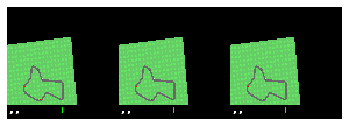

In [36]:
plt.imshow(all_images[0])
plt.axis('off')
plt.show()

In [63]:
filename = 'obs_sequence_all_carr.mp4'
with imageio.get_writer(filename, mode='I', macro_block_size=None) as video:    
    for image in range(len(all_images)):
        video.append_data(all_images[image])
embed_mp4(filename,video) 

### Compare z, state in different options

In [ ]:
pause_state, pause_z

In [18]:
xinput = np.concatenate([z, pause_state.h[0]])

In [29]:
action_normal

3

links (auch normal)

In [20]:
A_3 = [xinput] + [None]
A_3[1] = np.maximum(0,A_3[0].dot(model.weight) + model.bias)

In [21]:
R_3 = [None] + [A_3[1]*(3==np.arange(4))]

w = model.weight
wp = np.maximum(0,w)
wm = np.minimum(0,w)
lb = A_3[0]*0-1
hb = A_3[0]*0+1

z = A_3[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R_3[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R_3[0] = A_3[0]*c-lb*cp-hb*cm

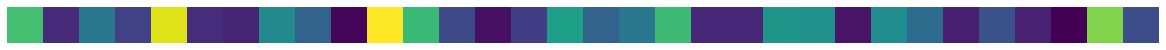

In [28]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
plt.axis('off')
plt.imshow(R_3[0][:32].reshape(1,32))
plt.show()

rechts

In [30]:
A_2 = [xinput] + [None]
A_2[1] = np.maximum(0,A_2[0].dot(model.weight) + model.bias)

In [31]:
R_2 = [None] + [A_2[1]*(2==np.arange(4))]

w = model.weight
wp = np.maximum(0,w)
wm = np.minimum(0,w)
lb = A_2[0]*0-1
hb = A_2[0]*0+1

z = A_2[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R_2[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R_2[0] = A_2[0]*c-lb*cp-hb*cm

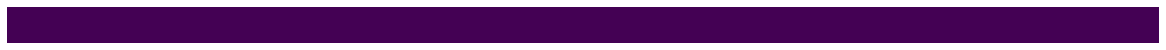

In [32]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
plt.axis('off')
plt.imshow(R_2[0][:32].reshape(1,32))
plt.show()

In [33]:
R_2[0][:32]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])